# Order-restricted one-sample comparison

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf
import keras

INFO:bayesflow:Using backend 'jax'

The models are essentially the same as in the previous example on
one-sample comparison, the difference is in the alternative model, where
instead of having a Cauchy prior on the $\delta$, we restrict it to only
negative values.

### Simulator

We need to define two simulator: one that represents the null hypothesis
that $\delta = 0$, and one that represents the alternative hypothesis
that $\delta < 0$. Then, we wrap them in a `ModelComparisonSimulator`,
that will sample from either of them randomly.

We will also amortize over different sample sizes. Here we do this by
randomly sampling values between 10 and 100. In the simulators, we will
make sure that the output is always of length 100 (maximum sample size);
the elements in the array whose index exceeds the actual sample size are
filled with zeros. To make it easier for the networks to summarise such
data, we will also create a binary indicator variable `observed`, which
is one when the element in `x` is filled with an actual value, and zero
otherwise.

In [2]:
max_n=100
def context():
    return dict(n=np.random.randint(10, max_n))

def prior_nuisance():
    sigma = np.random.standard_cauchy()
    sigma = np.abs(sigma)
    return dict(sigma=sigma)

def prior_null():
    return dict(delta=0)

def prior_alternative():
    delta = np.random.standard_cauchy()
    delta = - np.abs(delta)
    return dict(delta=delta)

def likelihood(sigma, delta, n):
    mu = sigma * delta
    x = np.zeros(max_n)
    x[:n] = np.random.normal(loc=mu, scale=sigma, size=n)

    observed = np.zeros(max_n)
    observed[:n] = 1

    return dict(x=x, observed=observed)

In [3]:
simulator_null = bf.make_simulator([context, prior_nuisance, prior_null, likelihood])
simulator_alt = bf.make_simulator([context, prior_nuisance, prior_alternative, likelihood])

simulator = bf.simulators.ModelComparisonSimulator([simulator_null, simulator_alt])

### Approximator

The sample size is passed into the inference network directly, and the
observations in `x` and the `observed` indicator are passed into a
summary network first.

In [4]:
adapter=(
    bf.Adapter()
    .as_set(["x", "observed"])
    .rename("n", "classifier_conditions")
    .concatenate(["x", "observed"], into="summary_variables")
    .drop(["delta","sigma"])
    )

Model comparison needs a classifier network to predict the posterior
model probabilities. Here, we define a simple multi-layer perceptron to
do this task.

In [5]:
inference_network = keras.Sequential([
    keras.layers.Dense(32, activation="gelu")
    for _ in range(6)
])

Then we wrap everything together.

In [6]:
approximator=bf.approximators.ModelComparisonApproximator(
    num_models=2,
    classifier_network=inference_network, 
    summary_network=bf.networks.DeepSet(
        summary_dim=4,
        mlp_widths_equivariant=(32, 32),
        mlp_widths_invariant_inner=(32, 32),
        mlp_widths_invariant_outer=(32, 32),
        mlp_widths_invariant_last=(32, 32)
    ),
    adapter=adapter
)

### Training

Here we will do offline traing. First, we will define the number of
epochs, and the simulation budget (number of batches times the batch
size). We also define an optimizer with a cosine decay schedule.

In [7]:
epochs=30
batches=20
batch_size=512
schedule=keras.optimizers.schedules.CosineDecay(1e-4, decay_steps=epochs*batches)
optimizer=keras.optimizers.Adam(schedule)
approximator.compile(optimizer)

Now we can prepare our training dataset.

In [8]:
train_data=simulator.sample(batches*batch_size)

train_data=bf.datasets.OfflineDataset(
    data=train_data, 
    batch_size=batch_size, 
    adapter=adapter)

In [ ]:
history=approximator.fit(
    dataset=train_data,
    epochs=epochs, 
    num_batches=batches, 
    batch_size=batch_size)

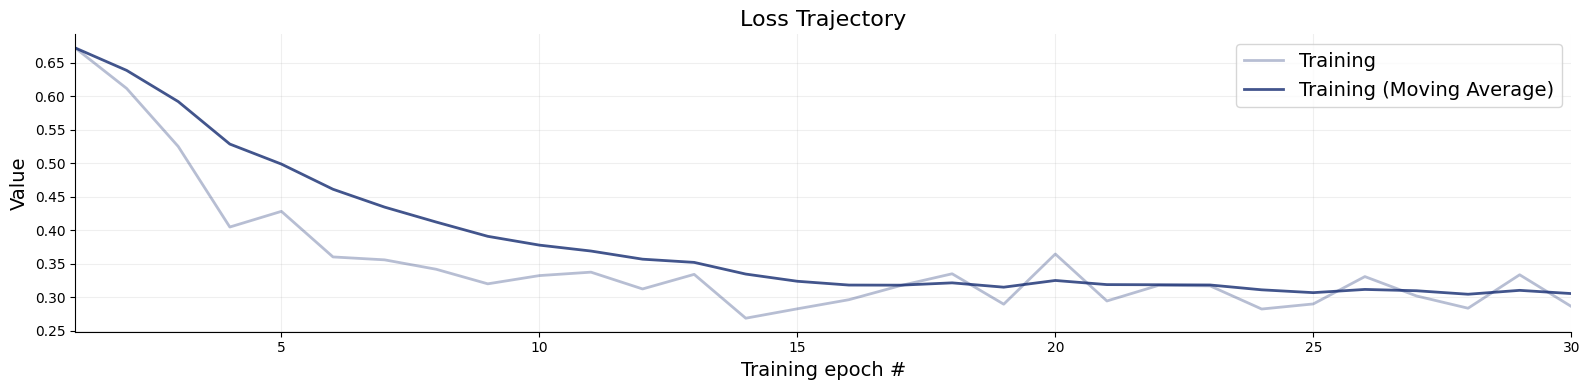

In [10]:
f=bf.diagnostics.plots.loss(history=history)

### Validation

In [11]:
test_data=simulator.sample(1000)

In [12]:
true_models = test_data["model_indices"]
pred_models = approximator.predict(conditions=test_data)

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode

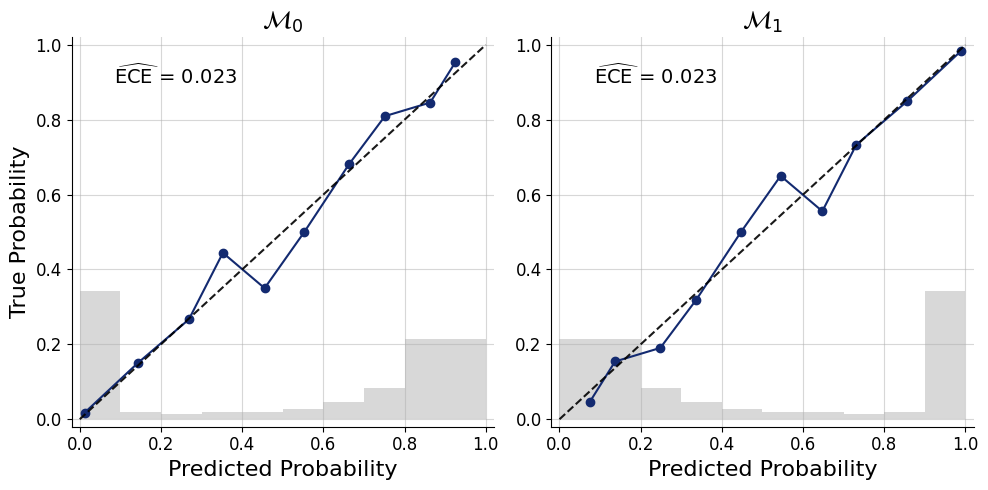

In [13]:
f=bf.diagnostics.plots.mc_calibration(
    pred_models=pred_models,
    true_models=true_models,
    model_names=[r"$\mathcal{M}_0$",r"$\mathcal{M}_1$"],
)

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode

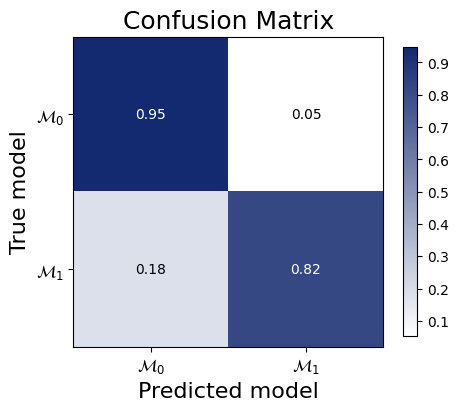

In [14]:
f=bf.diagnostics.plots.mc_confusion_matrix(
    pred_models=pred_models,
    true_models=true_models,
    model_names=[r"$\mathcal{M}_0$",r"$\mathcal{M}_1$"],
    normalize="true"
)

### Inference

In [15]:
winter=np.array([-0.05,0.41,0.17,-0.13,0.00,-0.05,0.00,0.17,0.29,0.04,0.21,0.08,0.37,0.17,0.08,-0.04,-0.04,0.04,-0.13,-0.12,0.04,0.21,0.17,
       0.17,0.17,0.33,0.04,0.04,0.04,0.00,0.21,0.13,0.25,-0.05,0.29,0.42,-0.05,0.12,0.04,0.25,0.12])
summer=np.array([0.00,0.38,-0.12,0.12,0.25,0.12,0.13,0.37,0.00,0.50,0.00,0.00,-0.13,-0.37,-0.25,-0.12,0.50,0.25,0.13,0.25,0.25,0.38,0.25,0.12,
      0.00,0.00,0.00,0.00,0.25,0.13,-0.25,-0.38,-0.13,-0.25,0.00,0.00,-0.12,0.25,0.00,0.50,0.00])
n = len(winter)

x = np.zeros(max_n)
x[:n] = winter-summer
observed = np.zeros(max_n)
observed[:n] = 1

inference_data = dict(
    n = np.array([[n]]),
    x = x[np.newaxis],
    observed = observed[np.newaxis]
)

In [16]:
pred_models = approximator.predict(conditions=inference_data)[0]

In [17]:
pred_models[0]/pred_models[1]

7.3406186